# Factor Analysis for Face Recognition

Assign a label indicating which of $M$ possible identities a face belongs to, based on a vector of grayscale pixel intensities $x$. Model the likelihood for each class using a factor analyzer:

$$
    \text{Pr}(x \ | \ w_i = k) = \text{Norm}_{x}(\mu_k, \phi_k\phi_k^T + \Sigma_k)\\[0.7em]
$$
Learn the parameters for the $k$th identity using the images of faces corresponding to that identity. Use expecation maximization to learn these parameters. Assign priors $\text{Pr}(w = k)$ according to each face's prevalence in the database. To evaluate a new face image $x_i$, compute the posterior $\text{Pr}(w_i|x_i)$.

In [7]:
# Data:            Continuous - vectors of grayscale pixel intensities.
# World states:    Discrete - categories corresponding to face identities.
# Model:           Generative - factor analyzers each parameterized by unique means, factors, and diagonal covariance matrices.
# Learning:        Expectation maximization of each model's parameters against images of their corresponding face IDs.
# Inference:       Computation of the posterior over face IDs, given an input face image vector.

# Requirements:
#             -> [st] training_data[]    - Array with rows of grayscale face images 
#             -> [st] training_labels[]  - Vector of the faces' corresponding IDs
#             -> [fn] dnorm()            - Multivariate normal density function
#             -> [fn] posterior()        - Receives image vector, returns class probabilities
#             -> [st] priors[]           - Class priors indexed by world state
#             -> [fn] fit_priors()       - Receives training set, returns vector of class priors
#             -> [fn] likelihood()       - Receives image vector + world state, returns probability
#             -> [fn] fit_likelihoods()  - Iterates over world states and fits their corresponding likelihood functions
#             -> [fn] EM()               - Maximizes likelihood for fit_likelihoods()
#             -> [fn] E_step()           - Computes hidden variable posteriors for EM()
#             -> [fn] M_step()           - Maximizes boundary w.r.t. likelihood fn parameters for EM()
#             -> [fn] boundary()         - Computes boundary value for EM()
#             -> [st] likelihood_params[]- List containing parameters corresponding to kth likelihood function
#             -> [st] test_data[]        - Vector of test image grayscale pixel intensities

#` 1. Import and flatten the data.
#` 2. Fit the prior distribution     : prior = fit_prior(vector of class labels)
#`    1.1. Compute and return the relative class sizes.
#` 3. Fit the likelihood distribution: likelihood_parameters = fit_likelihood(matrix of image vectors, vector of class labels, n_factors)
#`   3.1. Iterate over each class and maximize its images' likelihoods - Pr(x|w,th) - wr.t. th via EM.
#        -> Call: [mu_k, phi_k, covar_k] = EM(matrix of class image vectors, n_factors)
#       3.1.1. Randomly initialize vector mu_k, matrix phi_k, diag. matrix covar_k.
#       3.1.2. E_step(): Maximize the boundary w.r.t. the density functions over the hidden variable.
#       3.1.3. M_step(): Maximize the boundary's value w.r.t. mu_k, phi_k, and covar_k.
#       3.1.4. boundary(): Compute the boundary's value given the parameters and density functions.
#`    3.2. Store [mu_k, phi_k, covar_k] in an array such that they are indexed by world state.
#`    3.3. Return the array of parameter values.
#  4. Inference: [vector of class probabilities] = posterior(input_vec, parameter_arr)
#    4.1. Compute the product likelihood(input_vec, parameter_arr, k)*prior[k] for all world states k.
#       4.1.1. likelihood() is a multivariate normal density calculation.
#    4.2. Normalize and return this vector of unnormalized probabilities.
# 5. Display the image along with the computed class probabilities.

# What do the factors represent? Directions in which covariance is greatest among pixels.
# *Extracting the factors and plotting them as images would be interesting

In [32]:
import glob
import pytest
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# Import and label the training data
face_ids        = [fp[-6:] for fp in glob.iglob('.\\data\\face-identification\\select-faces\\*')]
face_fps        = glob.glob('.\\data\\face-identification\\select-faces\\*\\*.jpg')
training_data   = np.array([np.ravel(imresize(imread(fp, flatten=True)/255, size = [50, 50])) for fp in face_fps])
training_labels = [face_ids.index(name) for name in [fp.split('\\')[-2] for fp in face_fps]]

In [41]:
# Test functions for fit_likelihood()
def test_likelihood_inputs(training_data, training_labels, n_factors):
    assert n_factors > 0
    assert type(training_labels)    == list
    assert type(training_data)      == np.ndarray
    assert type(training_labels[0]) == int
    assert len(training_labels)     == training_data.shape[0]

def test_likelihood_outputs(klikelihood_params, datum_length, n_factors):
    assert test_likelihood_mean_dim(klikelihood_params[1], datum_length)
    assert test_likelihood_factor_dim(klikelihood_params[2], datum_length, n_factors)
    assert test_likelihood_covar_dim(klikelihood_params[3], datum_length)
    assert test_likelihood_covar_psd(klikelihood_params[3])
    assert test_likelihood_covar_sym(klikelihood_params[3])

def test_likelihood_mean_dim(mean_vector, datum_length):
    assert len(mean_vector) == datum_length

def test_likelihood_factor_dim(factor_matrix, datum_length, n_factors):
    assert factor_matrix.shape == (datum_length, n_factors)

def test_likelihood_covar_positive(covar_matrix):
    assert np.all(covar_matrix >= 0)
    
def test_likelihood_covar_dim(covar_matrix, datum_length):
    assert covar_matrix.shape == (datum_length, datum_length)
    
def test_likelihood_covar_sym(covar_matrix):
    assert np.all(covar_matrix == covar_matrix.T)

def test_likelihood_covar_psd(covar_matrix):
    assert np.all(np.linalg.eigvals(covar_matrix) >= 0)

In [42]:
def fit_prior(training_labels):
    # Receives a list of training labels indicating face ID
    # Returns a numpy array of ID prior probabilities
    priors = [sum(training_labels == ID)/len(training_labels) for ID in np.unique(training_labels)]
    return np.array(priors)

In [43]:
def fit_likelihood(training_data, training_labels, n_factors):
    # training_data   -> numpy array with rows of grayscale image vectors
    # training_labels -> list of associated integer face IDs
    # n_factors       -> Number of factors to use in factor analyzer
    # Iterates over world states and fits the parameters of their associated likelihood distributions
    test_likelihood_inputs(training_data, training_labels, n_factors)
    class_IDs         = np.unique(training_labels)
    likelihood_params = [None]*len(class_IDs) # List containing a set of parameters for each world state
    datum_length      = training_data.shape[1]
    for k in np.unique(class_IDs):
        k_data               = training_data[training_labels == k, :] # Images containing kth person
        klikelihood_params   = EM(k_data, n_factors, datum_length) # Fit the kth FA's parameters -> [mu_k, phi_k, covar_k]
        #assert test_likelihood_outputs(klikelihood_params, datum_length, n_factors)
        likelihood_params[k] = klikelihood_params
    return likelihood_params

In [44]:
def EM(training_data, n_factors, datum_length):
    # Returns parameters that fit a factor analyzer to the given data
    # training_data -> np array with rows of vectorized input images
    # n_factors     -> Number of factors to model the data's covariance with
    # 1. Randomly initialize parameters
    training_data = np.mat(training_data)
    mu_upd      = np.mat(np.random.uniform([1]*datum_length)).T # Vector
    phi_upd     = np.mat([np.random.normal(size = n_factors) for _ in range(datum_length)]) # Matrix
    covar_upd   = np.mat(np.random.normal(0, 100)*np.identity(datum_length))
    n_datum = training_data.shape[0]
    # 2. Iterate over E and M steps until boundary ceases to shift
    error = 1e5
    while (error > 1) :
        [mu, phi, covar]             = [mu_upd, phi_upd, covar_upd]
        expectations                 = E_step(training_data, mu, phi, covar, n_datum) # [N x 2] np.array: [(E[h_i], E[h_i h_i.T]), ...]
        [mu_upd, phi_upd, covar_upd] = M_step(training_data, expectations, n_datum) #
        mu_error                    = np.max(abs(mu_upd - mu))
        phi_error                   = np.max(abs(phi_upd - phi))
        covar_error                 = np.max(abs(covar_upd - covar))
        error = max([phi_error, mu_error, covar_error])
        print(error)
    return [mu_upd, phi_upd, covar_upd]
# The hidden variable is a vector describing the shift in the normal's mean through the subspace - this shift is conditional
# on each image, meaning that well-represented images will produce many shifts to a particular part of the subspace. This
# further means that the factors will tend to be aligned in the direction of shift (see the computation of the factors in
# the M-step).

In [45]:
def E_step(training_data, mu, phi, covar, n_datum):
    I  = np.identity(phi.shape[1])
    expectations = [None]*n_datum
    for i in range(n_datum):
        x                = np.mat(training_data[i, :]).T
        inv_term         = np.linalg.inv(phi.T * np.diag(1/np.diag(covar)) * phi + I)
        E_h              = inv_term * phi.T  * np.diag(1/np.diag(covar)) * (x - mu)
        E_hh             = inv_term + E_h * E_h.T
        expectations[i]  = [E_h, E_hh]
    return expectations

In [46]:
def M_step(training_data, expectations, n_datum):
    x         = training_data
    # Mu
    mu_hat    = np.sum(training_data, axis = 0).T/n_datum
    # Phi
    list_E_h  = np.array([expec[0] for expec in expectations])
    list_E_hh = np.array([expec[1] for expec in expectations])
    phi_t1    = np.sum(np.array([(x[i, :].T - mu_hat) * list_E_h[i].T for i in range(n_datum)]), axis = 0)
    phi_t2    = np.linalg.inv(np.sum(list_E_hh, axis = 0))
    phi_hat   = np.mat(phi_t1) * np.mat(phi_t2)
    # Sigma
    sum_of_sq = 0
    for i in range(n_datum):
        sum_of_sq += np.diag(((x[i, :].T - mu_hat) * (x[i, :].T - mu_hat).T)
                             - (phi_hat * list_E_h[i] * (x[i, :].T - mu_hat).T))/n_datum
    covar_hat  = np.identity(len(mu_hat))
    np.fill_diagonal(covar_hat, sum_of_sq)
    return [mu_hat, phi_hat, covar_hat]

In [47]:
n_factors = 1
fit_parameters = fit_likelihood(training_data, training_labels, n_factors)

2011.36503356
1262.14918684
266.103541779
302.121345996
198.447806517
80.6063929915
30.0745586739
11.1272194707
4.12703770217
1.53412638016
0.57100258684
1807.61138843
1579.40775119
193.746803329
81.2031930013
44.005100597
26.222568785
16.3913614937
10.71217962
7.27184057377
5.13328835744
3.63523825043
2.58231370543
1.83926263358
1.31272831158
0.938332758914
1934.00135775
1840.76784818
60.3855655467
33.775147353
23.6271493027
16.5643714235
11.2882225335
7.57331585247
5.03429733331
3.32730036561
2.19085889397
1.43892940912
0.943432249378


(-0.5, 49.5, 49.5, -0.5)

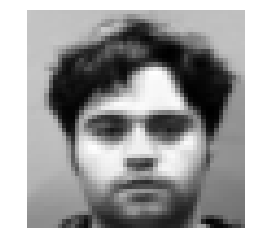

In [59]:
plt.imshow(np.reshape(fit_parameters[0][0], [50, 50]), cmap = 'gray');
plt.axis('off')